# Project: Sign Language Recognition

## Importing libraries

In [ ]:
import marimo as mo

In [ ]:
import numpy as np
import os
import re
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Reshape, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import pandas as pd
import time
import matplotlib.pyplot as plt
import splitfolders
import json

### Loading the ASL dataset and splitting into train and test

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debashishsau/aslamerican-sign-language-aplhabet-dataset")

print("Path to dataset files:", path)

File kaggle.json not found in the current directory!


In [ ]:
os.chdir(path)

<span class="codehilite"><div class="highlight"><pre><span></span><span class="gt">Traceback (most recent call last):</span>
  File <span class="nb">&quot;/usr/local/lib/python3.11/dist-packages/marimo/_runtime/executor.py&quot;</span>, line <span class="m">142</span>, in <span class="n">execute_cell</span>
<span class="w">    </span><span class="k">return</span> <span class="nb">eval</span><span class="p">(</span><span class="n">cell</span><span class="o">.</span><span class="n">last_expr</span><span class="p">,</span> <span class="n">glbls</span><span class="p">)</span>
<span class="w">           </span><span class="pm">^^^^^^^^^^^^^^^^^^^^^^^^^^^</span>
  File <span class="nb">&quot;/tmp/marimo_14/__marimo__cell_Xref_.py&quot;</span>, line <span class="m">1</span>, in <span class="n">&lt;module&gt;</span>
<span class="w">    </span><span class="n">ls</span>
<span class="gr">NameError</span>: <span class="n">name &#39;ls&#39; is not defined</span>
</pre></div>
</span>

In [ ]:
from pathlib import Path

# Path where our data is located
base_path = Path(path) / "ASL_Alphabet_Dataset" / "asl_alphabet_train"

# Dictionary to save our 29 classes
categories = {  0: "A",
                1: "B",
                2: "C",
                3: "D",
                4: "E",
                5: "F",
                6: "G",
                7: "H",
                8: "I",
                9: "G",
                10: "K",
                11: "L",
                12: "M",
                13: "N",
                14: "O",
                15: "P",
                16: "Q",
                17: "R",
                18: "S",
                19: "T",
                20: "U",
                21: "V",
                22: "W",
                23: "X",
                24: "Y",
                25: "Z",
                26: "del",
                27: "nothing",
                28: "space",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: f"class_{x}")
    return df

# List containing all the filenames in the dataset
filenames_list = []
# List to store the corresponding category; note that each folder of the dataset has one class of data
categories_list = []

for category_id, category_name in categories.items():
    category_path = base_path / category_name
    if category_path.exists() and category_path.is_dir():
        filenames = [file.name for file in category_path.iterdir() if file.is_file()]
        filenames_list.extend(filenames)
        categories_list.extend([category_id] * len(filenames))

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

Path to dataset files: /root/.cache/kagglehub/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset/versions/1


In [ ]:
output_path = Path('./asl_dataset_split')
if not output_path.exists():
    splitfolders.ratio(base_path, output=output_path, seed=1333, ratio=(0.8, 0.1, 0.1))

In [ ]:
# Define explicit paths for train, val, and test
train_path = output_path / 'train'
val_path = output_path / 'val'
test_path = output_path / 'test'

print(f"Train data saved at: {train_path}")
print(f"Validation data saved at: {val_path}")
print(f"Test data saved at: {test_path}")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
image_size = 64  # resizing images to 64x64
batch_size = 32  

# data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # normalize pixel values to [0, 1]
    validation_split=0.2  # split data into training and validation
)

# training data
train_data = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# validation data
val_data = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# test data
test_data = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Verifying shapes
print(f"Number of training samples: {train_data.samples}")
print(f"Number of validation samples: {val_data.samples}")
print(f"Number of test samples: {test_data.samples}")

## Load pretrained ResNet-50, building rnn, cnn and hybrid model

In [ ]:
# loading pretrained ResNet-50

def load_resnet_base(input_shape=(64, 64, 3)):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    return base_model

resnet_base_model = load_resnet_base()

Train data saved at: asl_dataset_split/train
Validation data saved at: asl_dataset_split/val
Test data saved at: asl_dataset_split/test


In [ ]:
def resnet_with_rnn(base_model, rnn_layers=2):
    base_model.trainable = False # we are freezing the base_model
    inputs = Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, -1))(x)
    for _ in range(rnn_layers):
        x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    outputs = Dense(29, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model 

resnet_rnn_model = resnet_with_rnn(resnet_base_model)

Found 142769 images belonging to 29 classes.


Found 35678 images belonging to 29 classes.


Found 22332 images belonging to 29 classes.


Number of training samples: 142769
Number of validation samples: 35678
Number of test samples: 22332


## Building the CNN model

In [ ]:
def resnet_with_cnn(base_model, cnn_layers=2):
    base_model.trainable = False # we are freezing the base_model
    inputs = Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    for _ in range(cnn_layers - 1):
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(29, activation='softmax')(x)  # Updated for 29 classes
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_cnn_model = resnet_with_cnn(resnet_base_model)

Load pretrained ResNet-50, building rnn, cnn and hybrid model

## Training the models

In [ ]:
def hybrid_resnet_cnn_rnn(base_model):
    base_model.trainable = False
    inputs = Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, -1))(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    outputs = Dense(29, activation='softmax')(x)  # Updated for 29 classes
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

hybrid_model = hybrid_resnet_cnn_rnn(resnet_base_model)

## Evaluating the models

In [ ]:
from types import SimpleNamespace

def evaluate_model(model, train_data, val_data, test_data, model_name, results, model_filename):
    weights_dir = Path(mo.notebook_dir()) / "weights"
    # Define file paths based on model_name
    weights_file = weights_dir / f"{model_filename}.weights.h5"
    history_file = weights_dir / f"{model_filename}_history.json"

    # Check if both weights and history files exist
    if weights_file.exists() and history_file.exists():
        print(f"Weights file found: {weights_file}. Loading weights...")
        model.load_weights(weights_file)

        print(f"History file found: {history_file}. Loading history...")

        with history_file.open('r') as f:
            history = SimpleNamespace(history = json.load(f))

        training_time = "-"
    else:

        # Early stopping callback to avoid overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the model
        start_time = time.time()
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=30,
            callbacks=[early_stopping],
            verbose=1
        )
        training_time = time.time() - start_time

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)

    # Log results
    results.append({
        'Model': model_name,
        'Validation Accuracy': max(history.history['val_accuracy']),
        'Test Accuracy': test_accuracy,
        'Training Time (s)': training_time
    })

    # Plot training history
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Training/Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    return history

### Resnet50

In [ ]:
results = []

# evaluate all models
history_resnet_rnn = evaluate_model(resnet_rnn_model, train_data, val_data, test_data, "ResNet50 + RNN", results, "r50_rnn")
history_resnet_cnn = evaluate_model(resnet_cnn_model, train_data, val_data, test_data, "ResNet50 + CNN", results, "r50_cnn")
history_hybrid = evaluate_model(hybrid_model, train_data, val_data, test_data, "Hybrid ResNet50 (CNN + RNN)", results, "r50_hybrid")

# convert results to DataFrame
results_df = pd.DataFrame(results)

# display the results
results_df

### Resnetv2

In [ ]:
v2_base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

v2_rnn_model = resnet_with_rnn(v2_base_model)
v2_cnn_model = resnet_with_cnn(v2_base_model)
v2_hybrid = hybrid_resnet_cnn_rnn(v2_base_model)

Weights file found: /app/weights/r50_rnn.weights.h5. Loading weights...


History file found: /app/weights/r50_rnn_history.json. Loading history...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Weights file found: /app/weights/r50_cnn.weights.h5. Loading weights...


History file found: /app/weights/r50_cnn_history.json. Loading history...


Weights file found: /app/weights/r50_hybrid.weights.h5. Loading weights...


History file found: /app/weights/r50_hybrid_history.json. Loading history...


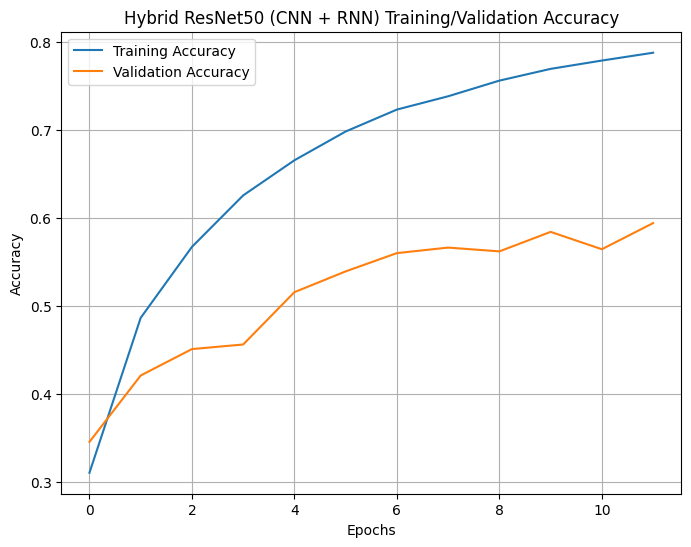

In [ ]:
v2_results = []

# evaluate all models
history_r50v2_rnn = evaluate_model(v2_rnn_model, train_data, val_data, test_data, "ResNet50v2 + RNN", v2_results, "r50v2_rnn")
history_r50v2_cnn = evaluate_model(v2_cnn_model, train_data, val_data, test_data, "ResNet50v2 + CNN", v2_results, "r50v2_cnn")
history_r50v2_hybrid = evaluate_model(v2_hybrid, train_data, val_data, test_data, "Hybrid ResNet50v2 (CNN + RNN)", v2_results, "r50v2_hybrid")

# convert results to DataFrame
v2_results_df = pd.DataFrame(v2_results)

# display the results
v2_results_df

### Resnet101v2

In [ ]:
r101_base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

r101_rnn_model = resnet_with_rnn(r101_base_model)
r101_cnn_model = resnet_with_cnn(r101_base_model)
r101_hybrid = hybrid_resnet_cnn_rnn(r101_base_model)

In [ ]:
r101_results = []

# evaluate all models
history_r101v2_rnn = evaluate_model(r101_rnn_model, train_data, val_data, test_data, "ResNet101v2 + RNN", r101_results, "r101v2_rnn")
history_r101v2_cnn = evaluate_model(r101_cnn_model, train_data, val_data, test_data, "ResNet101v2 + CNN", r101_results, "r101v2_cnn")
history_r101v2_hybrid = evaluate_model(r101_hybrid, train_data, val_data, test_data, "Hybrid ResNet101v2 (CNN + RNN)", r101_results, "r101v2_hybrid")

# convert results to DataFrame
r101_results_df = pd.DataFrame(r101_results)

# display the results
r101_results_df

## Saving Select Models

In [ ]:
weights_dir = Path(mo.notebook_dir()) / "weights"
weights_dir.mkdir(exist_ok=True)

resnet_rnn_model.save_weights(weights_dir / "r50_rnn.weights.h5")
resnet_cnn_model.save_weights(weights_dir / "r50_cnn.weights.h5")
hybrid_model.save_weights(weights_dir / "r50_hybrid.weights.h5")

json.dump(history_resnet_rnn.history, open(weights_dir / "r50_rnn_history.json", 'w' ))
json.dump(history_resnet_cnn.history, open(weights_dir / "r50_cnn_history.json", 'w' ))
json.dump(history_hybrid.history, open(weights_dir / "r50_hybrid_history.json", 'w' ))

v2_rnn_model.save_weights(weights_dir / "r50v2_rnn.weights.h5")
v2_cnn_model.save_weights(weights_dir / "r50v2_cnn.weights.h5")
v2_hybrid.save_weights(weights_dir / "r50v2_hybrid.weights.h5")

json.dump(history_r50v2_rnn.history, open(weights_dir / "r50v2_rnn_history.json", 'w' ))
json.dump(history_r50v2_cnn.history, open(weights_dir / "r50v2_cnn_history.json", 'w' ))
json.dump(history_r50v2_hybrid.history, open(weights_dir / "r50v2_hybrid_history.json", 'w' ))

r101_rnn_model.save_weights(weights_dir / "r101v2_rnn.weights.h5")
r101_cnn_model.save_weights(weights_dir / "r101v2_cnn.weights.h5")
r101_hybrid.save_weights(weights_dir / "r101v2_hybrid.weights.h5")

json.dump(history_r101v2_rnn.history, open(weights_dir / "r101v2_rnn_history.json", 'w' ))
json.dump(history_r101v2_cnn.history, open(weights_dir / "r101v2_cnn_history.json", 'w' ))
json.dump(history_r101v2_hybrid.history, open(weights_dir / "r101v2_hybrid_history.json", 'w' ))

### Loading Weights Example

In [ ]:
# Create a new model instance
test_model = resnet_with_cnn(r101_base_model)

# Restore the weights
test_model.load_weights(weights_dir / "r101v2_cnn.weights.h5")

print(test_model.evaluate(test_data, verbose=0))

## Plots and Charts for Report

In [ ]:
local_vars = dict(locals()).items()
histories = []
for var_name, var_value in local_vars:
    if var_name.startswith("history_"):
        histories.append({
            "name": var_name[len("history_"):],
            "accuracy": var_value.history["accuracy"],
            "val_accuracy": var_value.history["val_accuracy"]
        })

In [ ]:
# Prepare the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Colors for differentiation
colors = plt.cm.tab10(range(9))

# Plot accuracy
for i, history in enumerate(histories):
    axes[0].plot(history["accuracy"], label=f"{history['name']}", color=colors[i])
axes[0].set_title("Training Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Plot validation accuracy
for i, history in enumerate(histories):
    axes[1].plot(history["val_accuracy"], label=f"{history['name']}", color=colors[i])
axes[1].set_title("Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
all_results_df = pd.concat([results_df, v2_results_df , r101_results_df], axis=0)

# Update with values from Nora's run
all_results_df.loc[all_results_df["Model"] == "ResNet50 + RNN", "Validation Accuracy"] = .64
all_results_df.loc[all_results_df["Model"] == "ResNet50 + RNN", "Test Accuracy"] = 0.75

all_results_df.loc[all_results_df["Model"] == "ResNet50 + CNN", "Validation Accuracy"] = .49
all_results_df.loc[all_results_df["Model"] == "ResNet50 + CNN", "Test Accuracy"] = 0.56

all_results_df.loc[all_results_df["Model"] == "Hybrid ResNet50 (CNN + RNN)", "Validation Accuracy"] = .65
all_results_df.loc[all_results_df["Model"] == "Hybrid ResNet50 (CNN + RNN)", "Test Accuracy"] = 0.79


all_results_df = all_results_df.round(2)

all_results_df

In [ ]:
def grouped_bar(col_name):
    # Data
    barWidth = 0.25
    bars3 = all_results_df.loc[all_results_df["Model"].str.contains("Hybrid"), col_name]
    bars2 = all_results_df.loc[all_results_df["Model"].str.contains("\+ CNN"), col_name]
    bars1 = all_results_df.loc[all_results_df["Model"].str.endswith("RNN"), col_name]

    # Bar positions
    r = np.arange(len(bars1))
    r2 = r + barWidth
    r3 = r2 + barWidth

    # Plotting
    _, ax1 = plt.subplots(dpi=300)
    ax1.bar(r, bars1, color='red', width=barWidth, edgecolor='white', label='ResNet50')
    ax1.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='ResNet50v2')
    ax1.bar(r3, bars3, color='green', width=barWidth, edgecolor='white', label='ResNet101v2')

    # Xticks
    ax1.set_xticks(r + barWidth)
    ax1.set_xticklabels(['RNN', 'CNN', 'Hybrid'])

    ax1.set_ylim((0,1))

    ax1.set_title(col_name)

    # Legend and show
    ax1.legend()
    plt.show()

In [ ]:
grouped_bar("Validation Accuracy")

In [ ]:
grouped_bar("Test Accuracy")